# An Adversarial Perspective on "Overinterpretation Reveals Image Classification Model Pathologies"

Code for my blog post at https://sprin.xyz/articles/overinterpretation.html

In order to get this code to run, you will need the following dependencies (approximately):

* torch==1.10.1
* torchvision==0.11.2
* robustness==1.2.1
* numpy==1.22.0
* tqdm==4.62.3
* matplotlib==3.5.1

In addition, this file will output figures to the `figures` folder. Either remove the lines of code that output to this folder or create the folder.

In [1]:
# Global imports
import torch as ch
from robustness.datasets import ImageNet
from torchvision import models
from robustness.model_utils import make_and_restore_model
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from tqdm.notebook import tqdm
plt.style.use('seaborn-pastel')

## User to-do

For the code to run, you will need to modify the following cell to load the correct models
and images. I have tested the code on models loaded with the robustness library (https://github.com/MadryLab/robustness).

To use the same models that I used, download resnet50_l2_eps0 and resnet50_l2_eps3 from https://github.com/microsoft/robust-models-transfer

The ImageNet images and associated labels need to be in a numpy array as described below, 
although, in principle, any dataset of any image size should work, perhaps with some minimal
modification.

In [2]:
# Load models & dataset

# PyTorch or robustness-type standard model
# For example, I used the following code
#  m_resnet50, _ = make_and_restore_model(arch='resnet50', dataset=ds, \
#               resume_path='resnet50_l2_eps0.ckpt')
#  m_resnet50.eval()
m_resnet50 = ...

# PyTorch or robustness-type adversarially-trained model
# For example, I used the following code
#  m_resnet50_eps3, _ = make_and_restore_model(arch='resnet50', dataset=ds, \
#               resume_path='resnet50_l2_eps3.ckpt')
#  m_resnet50_eps3.eval()
m_resnet50_eps3 = ...

# An array of strings such that label_names[i] is the name of class i
label_names = ...

# A numpy array of shape (n, 3, 256, 256) for ImageNet or more generally (n, f, x, y) 
# corresponding to each of the n images that we will use for these experiments.
images = ...

# A numpy array of dimension (n) of type np.int32 where labels[i] is the label of images[i]
labels = ...

print('Loaded images and classifiers')

=> loading checkpoint '/scratch/jspring1/representation-similarity/pretrained/resnet50_l2_eps0.ckpt'
=> loaded checkpoint '/scratch/jspring1/representation-similarity/pretrained/resnet50_l2_eps0.ckpt' (epoch 90)
=> loading checkpoint '/scratch/jspring1/representation-similarity/pretrained/resnet50_l2_eps3.ckpt'
=> loaded checkpoint '/scratch/jspring1/representation-similarity/pretrained/resnet50_l2_eps3.ckpt' (epoch 90)
Loaded images and classifiers


In [3]:
# Batched Gradient SIS
def batched_gradient_sis(model, inp, lab,
                         threshold_best=0.9,
                         pixel_batch_size=256,
                         batch_size=32):
    n_batch = (inp.shape[0] + (batch_size-1)) // batch_size
    n_steps = (np.prod(inp.shape[2:]) + (pixel_batch_size-1)) // pixel_batch_size
    current_mask = np.zeros((inp.shape[0], inp.shape[2], inp.shape[3]), np.float32)
    best_mask = np.zeros_like(current_mask)
    best_confidence = np.zeros((inp.shape[0]), np.float32)
    masks = np.zeros((n_steps, inp.shape[0], inp.shape[2], inp.shape[3]), np.float32)
    confidences = np.zeros((n_steps, inp.shape[0]), np.float32)
    for i in tqdm(range(n_batch)):
        batch_inp = ch.tensor(inp[i*batch_size : (i+1)*batch_size], 
                              requires_grad=False).cuda()
        batch_labels = ch.tensor(lab[i*batch_size : (i+1)*batch_size], dtype=ch.long).cuda()
        for j in tqdm(range(n_steps)):
            batch_mask = ch.tensor(current_mask[i*batch_size : (i+1)*batch_size], requires_grad=True).cuda()
            batch_best = ch.tensor(best_mask[i*batch_size : (i+1)*batch_size]).cuda()
            old_confidence = ch.tensor(best_confidence[i*batch_size : (i+1)*batch_size]).cuda()
            inp_masked = ((batch_inp.swapaxes(0,1) * (1-batch_mask)) + (0.5 * batch_mask)).swapaxes(1,0)
            pred, _ = model(inp_masked)
            confidence = ch.softmax(pred, 1)[ch.arange(len(batch_labels)), batch_labels]
            mask_grad, = ch.autograd.grad(ch.sum(confidence), [batch_mask])
            # bit of a hack, ensures that the already-masked features are always the smallest in the list
            cutoff = ch.sort((ch.reshape(mask_grad - (ch.max(mask_grad)-ch.min(mask_grad)+1)*batch_mask, [len(mask_grad), -1]))).values[:, -pixel_batch_size]
            # computes new mask
            mask_update = ch.logical_or(batch_mask, 
                                        ((mask_grad.swapaxes(0,1).swapaxes(1,2)) >= cutoff)
                                        .swapaxes(2,1).swapaxes(1,0)).type(ch.float32)
            best_mask_update = ch.where((confidence > threshold_best)[:, None, None], batch_mask, batch_best)
            best_confidence_update = ch.where((confidence > threshold_best), confidence, old_confidence)
            current_mask[i*batch_size : (i+1)*batch_size] = mask_update.detach().cpu().numpy()
            best_mask[i*batch_size : (i+1)*batch_size] = best_mask_update.detach().cpu().numpy()
            best_confidence[i*batch_size : (i+1)*batch_size] = best_confidence_update.detach().cpu().numpy()
            masks[j][i*batch_size : (i+1)*batch_size] = current_mask[i*batch_size : (i+1)*batch_size]
            confidences[j][i*batch_size : (i+1)*batch_size] = confidence.detach().cpu().numpy()
            del batch_mask
            del batch_best
            del old_confidence
            del inp_masked
            del pred
            del confidence
            del mask_grad
            del cutoff
            del mask_update
            del best_mask_update
            del best_confidence_update
        del batch_inp
        del batch_labels
    return masks, confidences, best_mask, best_confidence

In [4]:
masks, confidences, best_mask, best_confidence = batched_gradient_sis(m_resnet50, images, labels)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

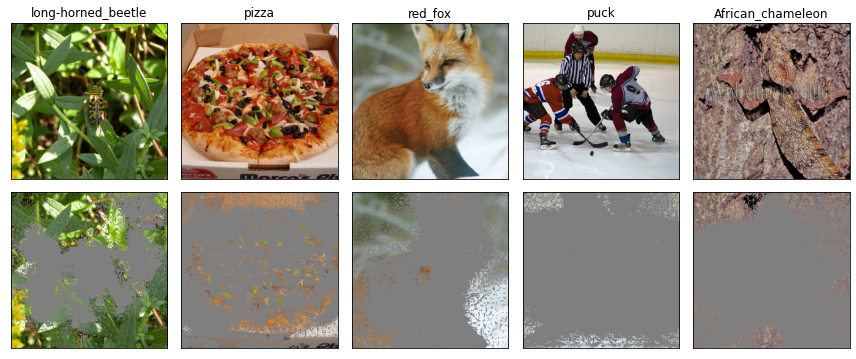

In [5]:
# Figure 1 -- Reproduction of Carter et al. Figure 4, but with ResNet50
# fig, axs = plt.subplots(3, 5, figsize=(10*1.2, 4.25*1.2*1.5))  # uncomment along with lines below for masks
fig, axs = plt.subplots(2, 5, figsize=(10*1.2, 4.25*1.2))
axs = np.array(axs)
for i, ax in enumerate(axs[0]):
    ax.set_title(label_names[labels[i]])
    ax.imshow(images[i].swapaxes(0,1).swapaxes(1,2))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_position('top')
for i, ax in enumerate(axs[1]):
    ax.imshow(((1-best_mask[i]) * images[i] + best_mask[i] * 0.5).swapaxes(0,1).swapaxes(1,2))
    ax.set_xticks([])
    ax.set_yticks([])
# for i, ax in enumerate(axs[2]):
#     ax.imshow(1-best_mask[i])
#     ax.set_xticks([])
#     ax.set_yticks([])
fig.tight_layout()
plt.savefig('figures/figure1.png')

In [6]:
def blur_mask(mask, blur_size=3):
    mask_to_convolve = ch.tensor(1-mask[:, None, ...])
    mask_blurred = 1-(ch.nn.functional.conv2d(mask_to_convolve, ch.ones((1, 1, blur_size, blur_size)), padding='same')[:, 0] > 0).numpy().astype(np.float32)
    return mask_blurred

In [7]:
def get_confidence(model, inp, lab, batch_size=32):
    conf = np.zeros((inp.shape[0]), np.float32)
    n_batch = (inp.shape[0] + (batch_size-1)) // batch_size
    for i in tqdm(range(n_batch)):
        batch_inp = ch.tensor(inp[i*batch_size : (i+1)*batch_size], 
                              requires_grad=False).cuda()
        batch_labels = ch.tensor(lab[i*batch_size : (i+1)*batch_size], dtype=ch.long).cuda()
        pred, _ = model(batch_inp)
        batch_conf = ch.softmax(pred, 1)[ch.arange(len(batch_labels)), batch_labels]
        conf[i*batch_size : (i+1)*batch_size] = batch_conf.detach().cpu().numpy()
        del batch_inp
        del batch_labels
    return conf

In [8]:
blurred_best_mask = blur_mask(best_mask, blur_size=3)
blurred_masked_images = (1-blurred_best_mask[:, None]) * images + blurred_best_mask[:, None] * 0.5
best_masked_images = (1-best_mask[:, None]) * images + best_mask[:, None] * 0.5
im_conf = get_confidence(m_resnet50, images, labels)
best_conf = get_confidence(m_resnet50, best_masked_images, labels)
blurred_conf = get_confidence(m_resnet50, blurred_masked_images, labels)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

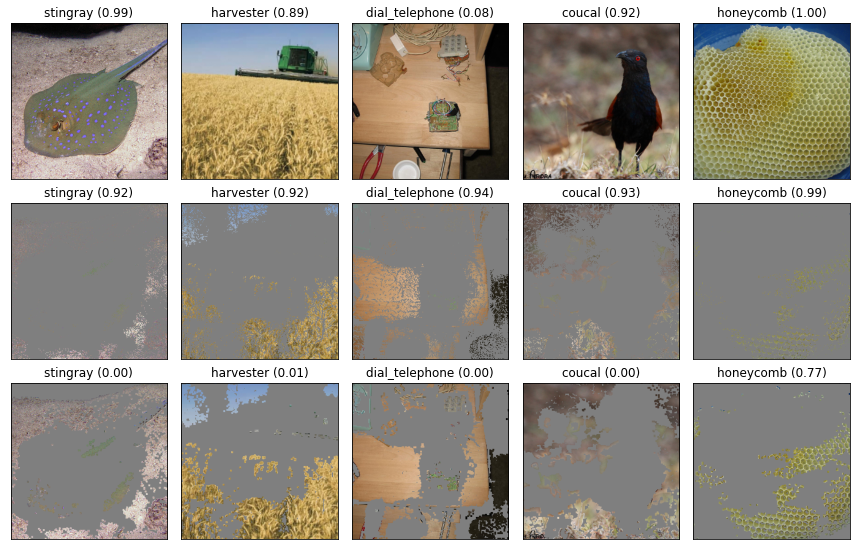

In [9]:
# Figure 3 -- Blurred mask
fig, axs = plt.subplots(3, 5, figsize=(10*1.2, 4.25*1.2*1.5))
axs = np.array(axs)
for i, ax in enumerate(axs[0]):
    # this is to select different images from Figure 1
    i += 5
    ax.set_title('{} ({:.2f})'.format(label_names[labels[i]], im_conf[i]))
    ax.imshow(images[i].swapaxes(0,1).swapaxes(1,2))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_position('top')
for i, ax in enumerate(axs[1]):
    i += 5
    ax.set_title('{} ({:.2f})'.format(label_names[labels[i]], best_conf[i]))
    ax.imshow(best_masked_images[i].swapaxes(0,1).swapaxes(1,2))
    ax.set_xticks([])
    ax.set_yticks([])
for i, ax in enumerate(axs[2]):
    i += 5
    ax.set_title('{} ({:.2f})'.format(label_names[labels[i]], blurred_conf[i]))
    ax.imshow(blurred_masked_images[i].swapaxes(0,1).swapaxes(1,2))
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.savefig('figures/figure3.png')

In [10]:
def compute_gradients(model, class_indices, inp, batch_size=32):
    grads = np.zeros_like(inp)
    for i in range((len(inp)+batch_size-1) // batch_size):
        batch = ch.tensor(inp[i*batch_size : (i+1)*batch_size], requires_grad=True).cuda()
        labels = class_indices[i*batch_size : (i+1)*batch_size]
        pred, _ = model(batch)
        grad_class, = ch.autograd.grad(ch.sum(pred[:, labels]), [batch])
        grads[i*batch_size : (i+1)*batch_size] = grad_class.detach().cpu().numpy()
        del batch
    return grads

def compute_smoothed_gradients(model, class_indices, inp, nsteps=100, scale=1., batch_size=32):
    smooth_grad = np.zeros_like(inp, dtype=np.float32)
    for i in tqdm(range(nsteps)):
        noisy_images = inp + np.random.normal(scale=scale/np.sqrt(np.prod(inp.shape[1:])), 
                                                      size=inp.shape).astype(np.float32)
        noisy_grad = compute_gradients(model, class_indices, noisy_images, batch_size=batch_size)
        smooth_grad += noisy_grad
    smooth_grad /= nsteps
    return smooth_grad

def saliency_from_smooth_grad(grad):
    candidates = np.max(np.abs(grad), axis=1)
    saliency = (candidates > np.mean(candidates) + np.std(candidates)).astype(np.float32)
    return saliency

In [11]:
im_smooth_grad = compute_smoothed_gradients(m_resnet50, labels, images)
best_masked_smooth_grad = compute_smoothed_gradients(m_resnet50, labels, best_masked_images)
blurred_masked_smooth_grad = compute_smoothed_gradients(m_resnet50, labels, blurred_masked_images)
im_saliency = saliency_from_smooth_grad(im_smooth_grad)
best_masked_saliency = saliency_from_smooth_grad(best_masked_smooth_grad)
blurred_masked_saliency = saliency_from_smooth_grad(blurred_masked_smooth_grad)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

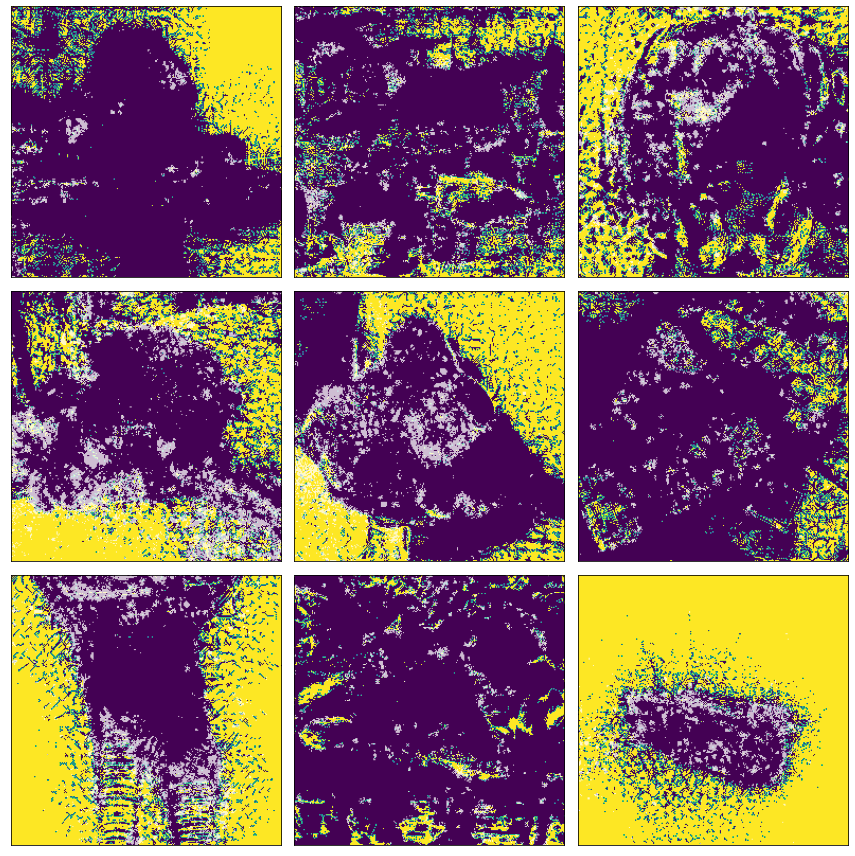

In [12]:
# Figure X -- Saliency (SmoothGrad) of sufficient input subsets   # excluded from blog but interesting, uncomment for figure
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = np.array(axs).reshape(-1)
for i, ax in enumerate(axs):
    # This is to select different images from Figures 1 and 3
    i += 10
    ax.imshow(1-best_mask[i])
    ax.imshow(np.ones_like(best_masked_saliency[i]), alpha=best_masked_saliency[i]*0.75, cmap='gray', vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.savefig('figures/figureX.png')

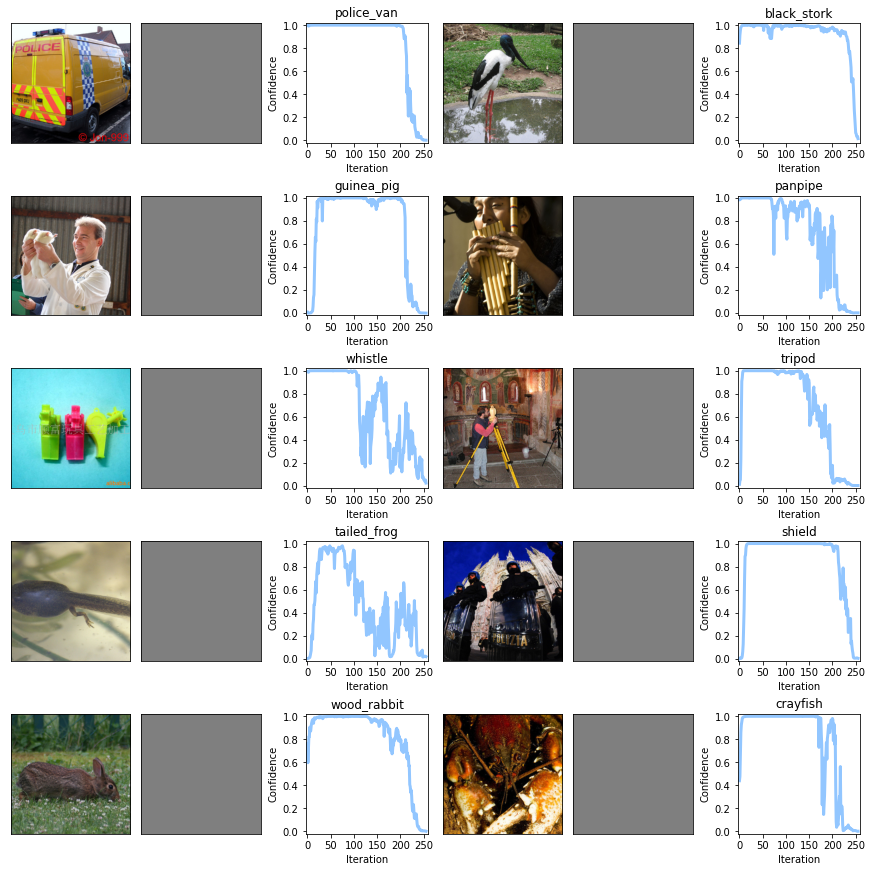

In [13]:
# Figure 5 -- Animation of the confidence over the iterations of Batched Gradient SIS

fig, axs = plt.subplots(5, 6, figsize=(12, 12), constrained_layout=True)
axs = np.array(axs).reshape(10, 3)

anim_data = []
for image_index, ax in enumerate(axs):
    # This is to select different images than previous Figures
    image_index += 19
    ax[2].set_title('{}'.format(label_names[labels[image_index]]))
    ax[2].set_xlim((0-4, 256+4))
    ax[2].set_ylim((0-0.02, 1+0.02))
    ax[2].set_xticks(np.arange(0, 256, 50))
    ax[2].set_yticks(np.arange(0, 1.1, 0.2))
    ax[2].set_ylabel('Confidence')
    ax[2].set_xlabel('Iteration')
    line, = ax[2].plot([], [], lw=3)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    im2 = ax[1].imshow(((1-masks[0][image_index]) * images[image_index] + \
                        masks[0][image_index] * 0.5).swapaxes(0,1).swapaxes(1,2), vmin=0, vmax=1)
    im1 = ax[0].imshow(images[image_index].swapaxes(0,1).swapaxes(1,2))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    anim_data.append([image_index, line, im1, im2])
    
def init():
    artists = []
    for _, line, im1, im2 in anim_data:
        artists.extend([line, im1, im2])
    return artists

def animate(i):
    for image_index, line, im1, im2 in anim_data:
        confidence_x = np.arange(len(confidences[:, image_index]), dtype=np.float32)
        confidence_y = confidences[:, image_index]
        line.set_data(confidence_x[:i+1], confidence_y[:i+1])
        im1.set_data(images[image_index].swapaxes(0,1).swapaxes(1,2))
        im2.set_data(((1-masks[i][image_index]) * images[image_index] + \
                      (0.5 * masks[i][image_index])).swapaxes(0,1).swapaxes(1,2))
    artists = []
    for _, line, im1, im2 in anim_data:
        artists.extend([line, im1, im2])
    return artists
    
anim = FuncAnimation(fig, animate, init_func=init,
                               frames=256, interval=10, blit=True)
writer = FFMpegWriter(fps=30)
anim.save(f'figures/figure4.mp4', writer=writer)

In [14]:
labels_adv = np.random.randint(low=0, high=1000, size=len(labels))
masks_adv, confidences_adv, best_mask_adv, best_confidence_adv = \
                batched_gradient_sis(m_resnet50, images, labels_adv)
adv_masked_images = (1-best_mask_adv[:, None]) * images + best_mask_adv[:, None] * 0.5
adv_conf = get_confidence(m_resnet50, adv_masked_images, labels_adv)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

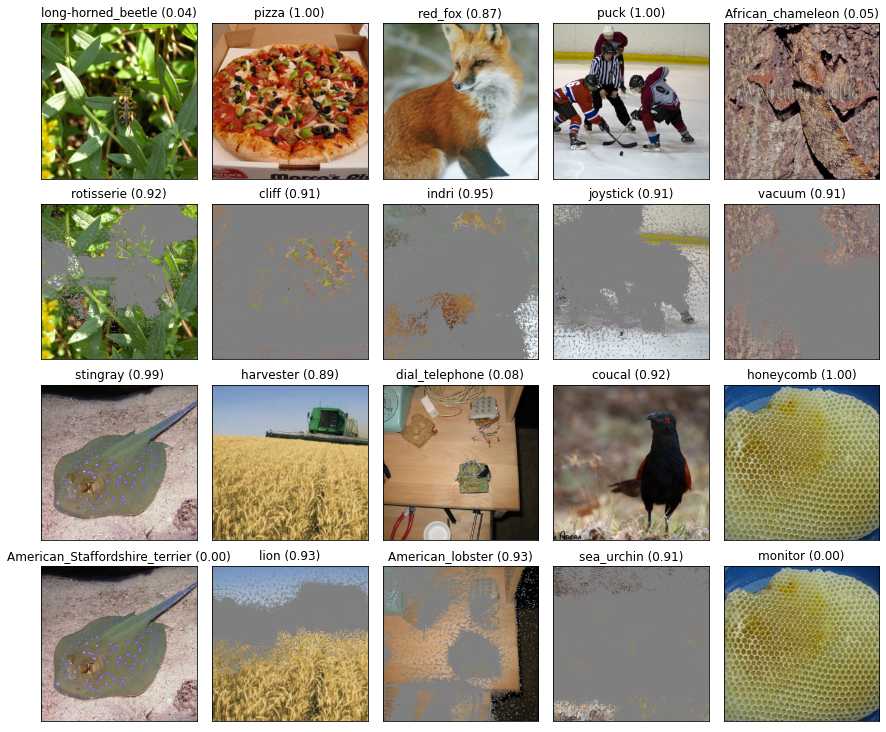

In [15]:
# Figure 6 -- Adversarial sufficient input subsets
fig, axs = plt.subplots(4, 5, figsize=(10*1.2, 4.25*1.2*2))
axs = np.array(axs)
for i, ax in enumerate(axs[0]):
    i = i
    ax.set_title('{} ({:.2f})'.format(label_names[labels[i]], im_conf[i]))
    ax.imshow(images[i].swapaxes(0,1).swapaxes(1,2))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_position('top')
for i, ax in enumerate(axs[1]):
    i = i
    ax.set_title('{} ({:.2f})'.format(label_names[labels_adv[i]], adv_conf[i]))
    ax.imshow(((1-best_mask_adv[i]) * images[i] + best_mask_adv[i] * 0.5).swapaxes(0,1).swapaxes(1,2))
    ax.set_xticks([])
    ax.set_yticks([])
for i, ax in enumerate(axs[2]):
    i = i+5
    ax.set_title('{} ({:.2f})'.format(label_names[labels[i]], im_conf[i]))
    ax.imshow(images[i].swapaxes(0,1).swapaxes(1,2))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_position('top')
for i, ax in enumerate(axs[3]):
    i = i+5
    ax.set_title('{} ({:.2f})'.format(label_names[labels_adv[i]], adv_conf[i]))
    ax.imshow(((1-best_mask_adv[i]) * images[i] + best_mask_adv[i] * 0.5).swapaxes(0,1).swapaxes(1,2))
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.savefig('figures/figure5.png')

In [16]:
rob_masks, rob_confidences, rob_best_mask, rob_best_confidence = \
            batched_gradient_sis(m_resnet50_eps3, images, labels, threshold_best=0.75)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

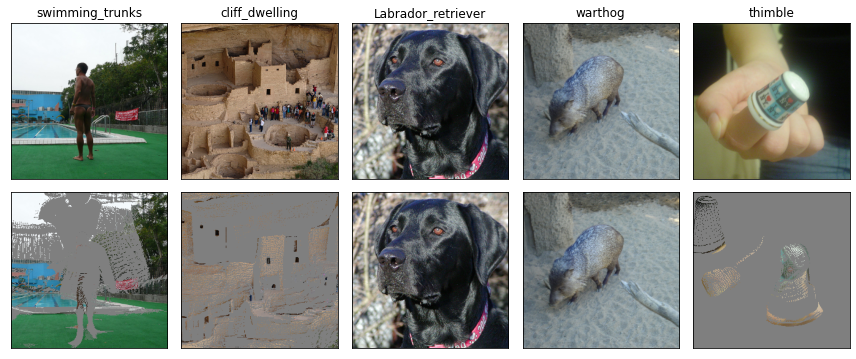

In [17]:
# Figure 7 -- Sufficient input subsets from an adversarially-trained robust classifier
# fig, axs = plt.subplots(3, 5, figsize=(10*1.2, 4.25*1.2*1.5))
fig, axs = plt.subplots(2, 5, figsize=(10*1.2, 4.25*1.2))
axs = np.array(axs)
for i, ax in enumerate(axs[0]):
    i = i+10
    ax.set_title(label_names[labels[i]])
    ax.imshow(images[i].swapaxes(0,1).swapaxes(1,2))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_position('top')
for i, ax in enumerate(axs[1]):
    i = i+10
    ax.imshow(((1-rob_best_mask[i]) * images[i] + rob_best_mask[i] * 0.5).swapaxes(0,1).swapaxes(1,2))
    ax.set_xticks([])
    ax.set_yticks([])
# for i, ax in enumerate(axs[2]):
#     i = i+10
#     ax.imshow(1-rob_best_mask[i])
#     ax.set_xticks([])
#     ax.set_yticks([])
fig.tight_layout()
plt.savefig('figures/figure6.png')